In [11]:
import logging as logger
import os
import shutil
import tarfile
from csv import reader
import logging as logger
import os
import shutil
import tarfile
from csv import reader

import cv2
import pandas as pd
import seaborn as sns

In [12]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style

## This sets the plot style
## to have a grid on a dark background
set_style("whitegrid")

# 1. Data loading

### load transformed .csv data

In [13]:
df=pd.read_csv("593_RZ_5037271_Aug-05-15-35-12.csv")
df.head()

,frame_id,score,duration,unclipped_reward,action,gaze_position_x,gaze_position_y
0,RZ_5037271_1,66481,611,0,0,79.85,105.17
1,RZ_5037271_1,66481,611,0,0,79.84,105.30
2,RZ_5037271_1,66481,611,0,0,79.83,105.30
3,RZ_5037271_1,66481,611,0,0,79.80,105.05
4,RZ_5037271_1,66481,611,0,0,79.79,104.78


### extract the head of frame_id

In [14]:
frameid=df['frame_id'].iloc[0].split('_')[0]+'_'+df['frame_id'].iloc[0].split('_')[1]+'_'
print(frameid)

RZ_5037271_


### combine all x,y position of the same frame into a single unit as a np array

In [15]:
uniqueid=df['frame_id'].unique()#find all unique frame_id

In [16]:
frame_id=[]
score=[]
duration=[]
unclipped_reward=[]
action=[]
xyarray=[]
for idnum in uniqueid:#iterate through all frame id
    xy=[]
#     print(idnum)
    dataf=df[df['frame_id']==idnum]#find the data with same frame_id as dataf
    #print(len(dataf.index))
    for ind in dataf.index:
        #print(ind)
        xy.append([df.iloc[ind]['gaze_position_x'],df.iloc[ind]['gaze_position_y']])#append all coordinate in a same frame_id
    xy=np.array(xy)
    firstindex=dataf.index[0]
    frame_id.append(df.iloc[firstindex]['frame_id'])
    score.append(df.iloc[firstindex]['score'])
    duration.append(df.iloc[firstindex]['duration'])
    unclipped_reward.append(df.iloc[firstindex]['unclipped_reward'])
    action.append(df.iloc[firstindex]['action'])
    xyarray.append(xy)
df_trans=pd.DataFrame({'frame_id':frame_id,'score':score,'duration':duration,
                      'unclipped_reward':unclipped_reward,'action':action,
                      'xyarray':xyarray})
#print(df_trans[['frame_id','score','duration','unclipped_reward','action']])
print(df_trans.head())
    

       frame_id  score  duration  unclipped_reward  action  \
0  RZ_5037271_1  66481       611                 0       0   
1  RZ_5037271_2  66481        49                 0       0   
2  RZ_5037271_3  66481      1606                 0       2   
3  RZ_5037271_4  66481        50                 0       2   
4  RZ_5037271_5  66481        51                 0       2   

                                             xyarray  
0  [[79.85, 105.17], [79.84, 105.3], [79.83, 105....  
1  [[78.61, 102.45], [78.59, 102.62], [78.58, 102...  
2  [[78.56, 102.45], [78.53, 102.55], [78.45, 102...  
3  [[121.71, 70.9], [121.66, 70.92], [121.65, 71....  
4  [[121.64, 71.35], [121.65, 71.38], [121.64, 71...  


In [17]:
df_trans.to_csv("593_RZ_5037271_Aug-05-15-35-12_trans.csv",index=False)

In [18]:
df_trans.head()

,frame_id,score,duration,unclipped_reward,action,xyarray
0,RZ_5037271_1,66481,611,0,0,"[[79.85, 105.17], [79.84, 105.3], [79.83, 105...."
1,RZ_5037271_2,66481,49,0,0,"[[78.61, 102.45], [78.59, 102.62], [78.58, 102..."
2,RZ_5037271_3,66481,1606,0,2,"[[78.56, 102.45], [78.53, 102.55], [78.45, 102..."
3,RZ_5037271_4,66481,50,0,2,"[[121.71, 70.9], [121.66, 70.92], [121.65, 71...."
4,RZ_5037271_5,66481,51,0,2,"[[121.64, 71.35], [121.65, 71.38], [121.64, 71..."


# 2. Extracting some features

### using pca to extract mean position, start position, end position, variance, component of gaze positions in each frame

In [19]:
from sklearn.decomposition import PCA
frame_id=[]
score=[]
duration=[]
unclipped_reward=[]
action=[]
start=[]
end=[]
mean=[]
variance0=[]
component0=[]
variance1=[]
component1=[]
for ind in df_trans.index:#iterate all frames
    if np.size(df_trans.iloc[ind]['xyarray'],axis=None)>=5:
        frame_id.append(df_trans.iloc[ind]['frame_id'])
        score.append(df_trans.iloc[ind]['score'])
        duration.append(df_trans.iloc[ind]['duration'])
        unclipped_reward.append(df_trans.iloc[ind]['unclipped_reward'])
        action.append(df_trans.iloc[ind]['action'])
        X=df_trans.iloc[ind]['xyarray']#X contains all gaze positions in one frame
        start.append(X[0])#store the start point 
        end.append(X[-1])#store the end point
        #using PCA to get the mean point, variance & component for two axes
        pca = PCA(2)
        pca.fit(X)
        mean.append(pca.mean_)
        variance0.append(pca.explained_variance_[0])
        component0.append(pca.components_[0])
        variance1.append(pca.explained_variance_[1])
        component1.append(pca.components_[1])
    else:
        continue
#creat new dateframe
pcadf=pd.DataFrame({'frame_id':frame_id,'score':score,'duration':duration,
                    'unclipped_reward':unclipped_reward,'action':action,
                    'mean':mean,'start':start,'end':end,
                   'variance0':variance0,'component0':component0,
                   'variance1':variance1,'component1':component1})
pcadf
    

,frame_id,score,duration,unclipped_reward,action,mean,start,end,variance0,component0,variance1,component1
0,RZ_5037271_1,66481,611,0,0,"[79.76888707037645, 103.07081833060569]","[79.85, 105.17]","[78.65, 102.28]",6.047593,"[0.05419623279919483, -0.9985303041722746]",0.129888,"[-0.9985303041722746, -0.05419623279919483]"
1,RZ_5037271_2,66481,49,0,0,"[78.45897959183675, 102.41489795918369]","[78.61, 102.45]","[78.59, 102.33]",0.043056,"[-0.3394277104576812, -0.9406321434936488]",0.012704,"[-0.9406321434936488, 0.3394277104576812]"
2,RZ_5037271_3,66481,1606,0,2,"[97.81100871731012, 91.29350560398498]","[78.56, 102.45]","[121.76, 70.95]",675.124852,"[0.9341425989570179, 0.35689999273441875]",290.835732,"[0.35689999273441875, -0.9341425989570179]"
3,RZ_5037271_4,66481,50,0,2,"[121.63199999999995, 71.26759999999999]","[121.71, 70.9]","[121.62, 71.3]",0.035883,"[0.29259381909635307, -0.9562368205766868]",0.003952,"[-0.9562368205766868, -0.29259381909635307]"
4,RZ_5037271_5,66481,51,0,2,"[121.51607843137252, 71.19333333333334]","[121.64, 71.35]","[121.45, 71.17]",0.029144,"[-0.13066806163070968, -0.9914261735851403]",0.004015,"[0.9914261735851403, -0.13066806163070968]"
...,...,...,...,...,...,...,...,...,...,...,...,...
17288,RZ_5037271_17377,0,50,0,0,"[135.73, 19.004600000000003]","[145.45, 0.95]","[109.8, 56.4]",395.688773,"[-0.5519126455151615, 0.8339019317164673]",2.518257,"[0.8339019317164673, 0.5519126455151615]"
17289,RZ_5037271_17378,0,51,0,0,"[82.17803921568627, 124.31960784313726]","[108.06, 58.48]","[74.12, 161.2]",1239.961884,"[0.3005242198628307, -0.953774183586365]",3.795144,"[0.953774183586365, 0.3005242198628307]"
17290,RZ_5037271_17379,0,49,0,0,"[74.80428571428571, 156.434693877551]","[74.29, 161.3]","[75.0, 153.65]",4.611652,"[-0.04542736240457794, 0.9989676444935357]",0.013223,"[-0.9989676444935357, -0.04542736240457794]"
17291,RZ_5037271_17380,0,50,0,0,"[75.36460000000002, 153.02100000000002]","[75.01, 153.78]","[75.51, 152.45]",0.237944,"[-0.2854611998080767, 0.9583902667515638]",0.005927,"[0.9583902667515638, 0.2854611998080767]"


### extract the position of pac_man and possible action in each frame (here we only consider four possible action directions: up, right, left, down.)

In [20]:
def mostvalue(arr):#this function is used to find the most frequent number in 2D array matrix
    arr1=arr.flatten()
    if np.array_equal(arr1, np.array([])):
        return np.nan
    else:
        return np.bincount(arr1).argmax()
def possibleaction(trial,minrow,maxrow,mincol,maxcol): #extract the possible action by checking four blocks around pac_man in each frame
    action=[]
    right=trial[minrow:maxrow,maxcol+1:maxcol+9]
    left=trial[minrow:maxrow,mincol-8:mincol]
    up=trial[minrow-8:minrow,mincol:maxcol]
    down=trial[maxrow+1:maxrow+9,mincol:maxcol]
    if mostvalue(up)<60:
        action.append(0)         # 0 means up action
    if mostvalue(right)<60:
        action.append(1)        # 1 means right action
    if mostvalue(left)<60:
        action.append(2)       # 2 means left action
    if mostvalue(down)<60:
        action.append(3)        # 3 means down action
    return action

In [21]:
import cv2 
import numpy as np
# path 
pac_position=[]# store the position of pac_man in each frame
poss_action=[]# store the possible action in each frame
for pic in pcadf['frame_id']:#iterate through all images
    path = "all_images\\"+pic+".png" #not included in the repository file, and all_images file should inclue all images in the
                                        #trial 593_RZ_5037271_Aug-05-15-35-12
    src = cv2.imread(path)#read each image
    image = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY )# Using cv2.COLOR_BGR2GRAY color space
    #print(image)
    trial=image

    result = np.where(trial == 167) #find the pac_man, 167 is the color space of pac_man
    #print(result)
    if np.size(result[0],axis=None)>=5:#make sure the number of pac_man points is large enough to satisfy the pca requirement
        lenresult=len(result[0])
        X=np.ones((lenresult,2)) # X is np array to store the points of pac_man
        X[:,0]=result[1]
        X[:,1]=result[0]
        #print(X)
        from sklearn.decomposition import PCA
        pca = PCA(2)

        ## Fit the data
        pca.fit(X)
        pac_position.append(pca.mean_)# using PCA, take mean point as the position of pac_man
        minrow=result[0].min()
        maxrow=result[0].max()
        mincol=result[1].min()
        maxcol=result[1].max()  # the above four parameters represent the range of pac_man
        poss_action.append(possibleaction(trial,minrow,maxrow,mincol,maxcol))
    else:
        pac_position.append(np.nan)
        poss_action.append(np.nan)
print(pac_position)
print(poss_action)

[array([ 79.82926829, 103.36585366]), array([125.88372093,  86.39534884]), array([125.88372093,  86.39534884]), array([125.88372093,  84.39534884]), array([125.88372093,  84.39534884]), array([125.91525424,  81.61016949]), array([125.91525424,  81.61016949]), array([125.91525424,  79.61016949]), array([125.91525424,  79.61016949]), array([125.88372093,  78.39534884]), array([125.88372093,  78.39534884]), array([125.88372093,  76.39534884]), array([125.88372093,  76.39534884]), array([125.86486486,  74.89189189]), array([125.86486486,  74.89189189]), array([125.86486486,  72.89189189]), array([125.86486486,  72.89189189]), array([125.88372093,  70.39534884]), array([125.88372093,  70.39534884]), array([125.88372093,  68.39534884]), array([125.88372093,  68.39534884]), array([125.91525424,  65.61016949]), array([125.91525424,  65.61016949]), array([125.91525424,  63.61016949]), array([125.91525424,  63.61016949]), array([125.88372093,  62.39534884]), array([125.88372093,  62.39534884]), 

In [22]:
dfpac_position=pd.DataFrame({'pac_position':pac_position,'pos_action':poss_action})
df1=pd.concat([pcadf,dfpac_position],axis=1)
df1 # create a new dataframe

,frame_id,score,duration,unclipped_reward,action,mean,start,end,variance0,component0,variance1,component1,pac_position,pos_action
0,RZ_5037271_1,66481,611,0,0,"[79.76888707037645, 103.07081833060569]","[79.85, 105.17]","[78.65, 102.28]",6.047593,"[0.05419623279919483, -0.9985303041722746]",0.129888,"[-0.9985303041722746, -0.05419623279919483]","[79.82926829268293, 103.36585365853658]","[1, 2]"
1,RZ_5037271_2,66481,49,0,0,"[78.45897959183675, 102.41489795918369]","[78.61, 102.45]","[78.59, 102.33]",0.043056,"[-0.3394277104576812, -0.9406321434936488]",0.012704,"[-0.9406321434936488, 0.3394277104576812]","[125.88372093023256, 86.3953488372093]","[0, 2, 3]"
2,RZ_5037271_3,66481,1606,0,2,"[97.81100871731012, 91.29350560398498]","[78.56, 102.45]","[121.76, 70.95]",675.124852,"[0.9341425989570179, 0.35689999273441875]",290.835732,"[0.35689999273441875, -0.9341425989570179]","[125.88372093023256, 86.3953488372093]","[0, 2, 3]"
3,RZ_5037271_4,66481,50,0,2,"[121.63199999999995, 71.26759999999999]","[121.71, 70.9]","[121.62, 71.3]",0.035883,"[0.29259381909635307, -0.9562368205766868]",0.003952,"[-0.9562368205766868, -0.29259381909635307]","[125.88372093023256, 84.3953488372093]","[0, 2, 3]"
4,RZ_5037271_5,66481,51,0,2,"[121.51607843137252, 71.19333333333334]","[121.64, 71.35]","[121.45, 71.17]",0.029144,"[-0.13066806163070968, -0.9914261735851403]",0.004015,"[0.9914261735851403, -0.13066806163070968]","[125.88372093023256, 84.3953488372093]","[0, 2, 3]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17288,RZ_5037271_17377,0,50,0,0,"[135.73, 19.004600000000003]","[145.45, 0.95]","[109.8, 56.4]",395.688773,"[-0.5519126455151615, 0.8339019317164673]",2.518257,"[0.8339019317164673, 0.5519126455151615]","[80.48387096774194, 103.3225806451613]","[1, 2]"
17289,RZ_5037271_17378,0,51,0,0,"[82.17803921568627, 124.31960784313726]","[108.06, 58.48]","[74.12, 161.2]",1239.961884,"[0.3005242198628307, -0.953774183586365]",3.795144,"[0.953774183586365, 0.3005242198628307]","[80.48387096774194, 103.3225806451613]","[1, 2]"
17290,RZ_5037271_17379,0,49,0,0,"[74.80428571428571, 156.434693877551]","[74.29, 161.3]","[75.0, 153.65]",4.611652,"[-0.04542736240457794, 0.9989676444935357]",0.013223,"[-0.9989676444935357, -0.04542736240457794]","[79.82926829268293, 103.36585365853658]","[1, 2]"
17291,RZ_5037271_17380,0,50,0,0,"[75.36460000000002, 153.02100000000002]","[75.01, 153.78]","[75.51, 152.45]",0.237944,"[-0.2854611998080767, 0.9583902667515638]",0.005927,"[0.9583902667515638, 0.2854611998080767]","[79.82926829268293, 103.36585365853658]","[1, 2]"


### calculate the angle and amplitude of the vector connecting gaze (mean,start,end) position and pac_man position. Also transform the pca component of gaze_position to an angle value.

In [23]:
mean_angle=[] #store the angle of the vector connecting mean gaze position and pac_man position
mean_amplitude=[]#store the amplitude of the vector connecting mean gaze position and pac_man position
for ind in df1.index:
    diff=df1.iloc[ind]['mean']-df1.iloc[ind]['pac_position']
    x=diff[0]
    y=diff[1]
    amp=np.sqrt(x**2+y**2)
    #print(x,y)
    if x<0 and y>0:
        theta=np.arctan(y/x)*180/np.pi+180
    elif x<0 and y<0:
        theta=np.arctan(y/x)*180/np.pi-180
    else:
        theta=np.arctan(y/x)*180/np.pi
    #print(theta,amp)
    mean_angle.append(theta)
    mean_amplitude.append(amp)
mean_angle_amp=pd.DataFrame({'mean_angle':mean_angle,'mean_amplitude':mean_amplitude})
mean_angle_amp

start_angle=[]#store the angle of the vector connecting start gaze position and pac_man position
start_amplitude=[]#store the amplitude of the vector connecting start gaze position and pac_man position
for ind in df1.index:
    diff=df1.iloc[ind]['start']-df1.iloc[ind]['pac_position']
    x=diff[0]
    y=diff[1]
    amp=np.sqrt(x**2+y**2)
    #print(x,y)
    if x<0 and y>0:
        theta=np.arctan(y/x)*180/np.pi+180
    elif x<0 and y<0:
        theta=np.arctan(y/x)*180/np.pi-180
    else:
        theta=np.arctan(y/x)*180/np.pi
    #print(theta,amp)
    start_angle.append(theta)
    start_amplitude.append(amp)
start_angle_amp=pd.DataFrame({'start_angle':start_angle,'start_amplitude':start_amplitude})
start_angle_amp

end_angle=[]#store the angle of the vector connecting end gaze position and pac_man position
end_amplitude=[]#store the amplitude of the vector connecting end gaze position and pac_man positionstart
for ind in df1.index:
    diff=df1.iloc[ind]['end']-df1.iloc[ind]['pac_position']
    x=diff[0]
    y=diff[1]
    amp=np.sqrt(x**2+y**2)
    #print(x,y)
    if x<0 and y>0:
        theta=np.arctan(y/x)*180/np.pi+180
    elif x<0 and y<0:
        theta=np.arctan(y/x)*180/np.pi-180
    else:
        theta=np.arctan(y/x)*180/np.pi
    #print(theta,amp)
    end_angle.append(theta)
    end_amplitude.append(amp)
end_angle_amp=pd.DataFrame({'end_angle':end_angle,'end_amplitude':end_amplitude})
end_angle_amp

com_angle0=[]#store the angle of the first component vector in the gaze positions
for ind in df1.index:
    diff=df1.iloc[ind]['component0']
    x=diff[0]
    y=diff[1]
    if x<0 and y>0:
        theta=np.arctan(y/x)*180/np.pi+180
    elif x<0 and y<0:
        theta=np.arctan(y/x)*180/np.pi-180
    else:
        theta=np.arctan(y/x)*180/np.pi
    #print(theta,amp)
    com_angle0.append(theta)
com_angle0_df=pd.DataFrame({'com_angle0':com_angle0})

com_angle1=[]#store the angle of the second component vector in the gaze positions
for ind in df1.index:
    diff=df1.iloc[ind]['component1']
    x=diff[0]
    y=diff[1]
    if x<0 and y>0:
        theta=np.arctan(y/x)*180/np.pi+180
    elif x<0 and y<0:
        theta=np.arctan(y/x)*180/np.pi-180
    else:
        theta=np.arctan(y/x)*180/np.pi
    #print(theta,amp)
    com_angle1.append(theta)
com_angle1_df=pd.DataFrame({'com_angle1':com_angle1})

df2=pd.concat([df1,mean_angle_amp,start_angle_amp,end_angle_amp,com_angle0_df,com_angle1_df],axis=1)
df2#create new dataframe

,frame_id,score,duration,unclipped_reward,action,mean,start,end,variance0,component0,...,pac_position,pos_action,mean_angle,mean_amplitude,start_angle,start_amplitude,end_angle,end_amplitude,com_angle0,com_angle1
0,RZ_5037271_1,66481,611,0,0,"[79.76888707037645, 103.07081833060569]","[79.85, 105.17]","[78.65, 102.28]",6.047593,"[0.05419623279919483, -0.9985303041722746]",...,"[79.82926829268293, 103.36585365853658]","[1, 2]",-101.566298,0.301151,89.341635,1.804265,-137.361565,1.603045,-86.893262,-176.893262
1,RZ_5037271_2,66481,49,0,0,"[78.45897959183675, 102.41489795918369]","[78.61, 102.45]","[78.59, 102.33]",0.043056,"[-0.3394277104576812, -0.9406321434936488]",...,"[125.88372093023256, 86.3953488372093]","[0, 2, 3]",161.335605,50.057288,161.241974,49.925510,161.379809,49.906003,-109.842011,160.157989
2,RZ_5037271_3,66481,1606,0,2,"[97.81100871731012, 91.29350560398498]","[78.56, 102.45]","[121.76, 70.95]",675.124852,"[0.9341425989570179, 0.35689999273441875]",...,"[125.88372093023256, 86.3953488372093]","[0, 2, 3]",170.102606,28.496826,161.260409,49.972856,-104.948598,15.986365,20.909936,-69.090064
3,RZ_5037271_4,66481,50,0,2,"[121.63199999999995, 71.26759999999999]","[121.71, 70.9]","[121.62, 71.3]",0.035883,"[0.29259381909635307, -0.9562368205766868]",...,"[125.88372093023256, 84.3953488372093]","[0, 2, 3]",-107.945729,13.799091,-107.185325,14.126018,-108.034756,13.771982,-72.986692,-162.986692
4,RZ_5037271_5,66481,51,0,2,"[121.51607843137252, 71.19333333333334]","[121.64, 71.35]","[121.45, 71.17]",0.029144,"[-0.13066806163070968, -0.9914261735851403]",...,"[125.88372093023256, 84.3953488372093]","[0, 2, 3]",-108.305842,13.905737,-108.019981,13.718247,-108.533426,13.948754,-97.508199,-7.508199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17288,RZ_5037271_17377,0,50,0,0,"[135.73, 19.004600000000003]","[145.45, 0.95]","[109.8, 56.4]",395.688773,"[-0.5519126455151615, 0.8339019317164673]",...,"[80.48387096774194, 103.3225806451613]","[1, 2]",-56.766713,100.805043,-57.600593,121.246621,-58.003823,55.327787,123.498328,33.498328
17289,RZ_5037271_17378,0,51,0,0,"[82.17803921568627, 124.31960784313726]","[108.06, 58.48]","[74.12, 161.2]",1239.961884,"[0.3005242198628307, -0.953774183586365]",...,"[80.48387096774194, 103.3225806451613]","[1, 2]",85.387020,21.065264,-58.410392,52.643138,96.274711,58.226236,-72.510908,17.489092
17290,RZ_5037271_17379,0,49,0,0,"[74.80428571428571, 156.434693877551]","[74.29, 161.3]","[75.0, 153.65]",4.611652,"[-0.04542736240457794, 0.9989676444935357]",...,"[79.82926829268293, 103.36585365853658]","[1, 2]",95.409096,53.306212,95.461629,58.198357,95.485837,50.515515,92.603692,-177.396308
17291,RZ_5037271_17380,0,50,0,0,"[75.36460000000002, 153.02100000000002]","[75.01, 153.78]","[75.51, 152.45]",0.237944,"[-0.2854611998080767, 0.9583902667515638]",...,"[79.82926829268293, 103.36585365853658]","[1, 2]",95.137849,49.855459,95.460516,50.643968,95.028915,49.273822,106.586419,16.586419


### drop rows with nan value

In [25]:
df2_drop=df2.dropna()
df3=df2_drop[['frame_id','action','variance0','com_angle0','variance1','com_angle1','pos_action',
                         'mean_angle','mean_amplitude','start_angle','start_amplitude','end_angle','end_amplitude']].copy().reset_index(drop=True)
df3

,frame_id,action,variance0,com_angle0,variance1,com_angle1,pos_action,mean_angle,mean_amplitude,start_angle,start_amplitude,end_angle,end_amplitude
0,RZ_5037271_1,0,6.047593,-86.893262,0.129888,-176.893262,"[1, 2]",-101.566298,0.301151,89.341635,1.804265,-137.361565,1.603045
1,RZ_5037271_2,0,0.043056,-109.842011,0.012704,160.157989,"[0, 2, 3]",161.335605,50.057288,161.241974,49.925510,161.379809,49.906003
2,RZ_5037271_3,2,675.124852,20.909936,290.835732,-69.090064,"[0, 2, 3]",170.102606,28.496826,161.260409,49.972856,-104.948598,15.986365
3,RZ_5037271_4,2,0.035883,-72.986692,0.003952,-162.986692,"[0, 2, 3]",-107.945729,13.799091,-107.185325,14.126018,-108.034756,13.771982
4,RZ_5037271_5,2,0.029144,-97.508199,0.004015,-7.508199,"[0, 2, 3]",-108.305842,13.905737,-108.019981,13.718247,-108.533426,13.948754
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16682,RZ_5037271_17377,0,395.688773,123.498328,2.518257,33.498328,"[1, 2]",-56.766713,100.805043,-57.600593,121.246621,-58.003823,55.327787
16683,RZ_5037271_17378,0,1239.961884,-72.510908,3.795144,17.489092,"[1, 2]",85.387020,21.065264,-58.410392,52.643138,96.274711,58.226236
16684,RZ_5037271_17379,0,4.611652,92.603692,0.013223,-177.396308,"[1, 2]",95.409096,53.306212,95.461629,58.198357,95.485837,50.515515
16685,RZ_5037271_17380,0,0.237944,106.586419,0.005927,16.586419,"[1, 2]",95.137849,49.855459,95.460516,50.643968,95.028915,49.273822


### pick out data with up, down, left, right action

In [26]:
df4=df3[(df3['action']==2) | (df3['action']==3) | (df3['action']==4) | (df3['action']==5)]
df4

,frame_id,action,variance0,com_angle0,variance1,com_angle1,pos_action,mean_angle,mean_amplitude,start_angle,start_amplitude,end_angle,end_amplitude
2,RZ_5037271_3,2,675.124852,20.909936,290.835732,-69.090064,"[0, 2, 3]",170.102606,28.496826,161.260409,49.972856,-104.948598,15.986365
3,RZ_5037271_4,2,0.035883,-72.986692,0.003952,-162.986692,"[0, 2, 3]",-107.945729,13.799091,-107.185325,14.126018,-108.034756,13.771982
4,RZ_5037271_5,2,0.029144,-97.508199,0.004015,-7.508199,"[0, 2, 3]",-108.305842,13.905737,-108.019981,13.718247,-108.533426,13.948754
5,RZ_5037271_6,2,0.070980,97.549158,0.008503,7.549158,"[0, 1, 2, 3]",-113.643011,11.329768,-112.825956,11.381482,-114.635915,11.287626
6,RZ_5037271_7,2,0.047391,95.946701,0.008704,-174.053299,"[0, 1, 2, 3]",-112.911807,11.766484,-114.404793,11.266875,-112.830973,11.946105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16611,RZ_5037271_17306,4,1.469895,107.107439,0.012684,17.107439,"[1, 2]",114.338379,170.906662,114.227716,173.210204,114.409012,169.460775
16612,RZ_5037271_17307,4,0.355787,-90.909502,0.007117,179.090498,"[1, 2]",114.535687,168.796607,114.426354,169.396198,114.754752,167.693789
16613,RZ_5037271_17308,4,121.790149,-91.365272,0.890204,178.634728,"[1, 2]",111.307934,194.162089,114.669279,168.382020,110.389077,199.140620
16614,RZ_5037271_17309,4,0.362737,84.028416,0.011814,-5.971584,"[1, 2]",110.525212,198.067893,110.404123,199.000024,110.641052,197.352773


### remapping the index of action from 2:up,3:right,4:left,5:down to 0:up,1:right,2:left,3:down

In [27]:
df5=df4.copy().reset_index(drop=True)
dict_map = {2:0,3:1,4:2,5:3}#0:up,1:right,2:left,3:down
updateSer = df5['action'].map(dict_map)
df5['action'] = updateSer
df5

,frame_id,action,variance0,com_angle0,variance1,com_angle1,pos_action,mean_angle,mean_amplitude,start_angle,start_amplitude,end_angle,end_amplitude
0,RZ_5037271_3,0,675.124852,20.909936,290.835732,-69.090064,"[0, 2, 3]",170.102606,28.496826,161.260409,49.972856,-104.948598,15.986365
1,RZ_5037271_4,0,0.035883,-72.986692,0.003952,-162.986692,"[0, 2, 3]",-107.945729,13.799091,-107.185325,14.126018,-108.034756,13.771982
2,RZ_5037271_5,0,0.029144,-97.508199,0.004015,-7.508199,"[0, 2, 3]",-108.305842,13.905737,-108.019981,13.718247,-108.533426,13.948754
3,RZ_5037271_6,0,0.070980,97.549158,0.008503,7.549158,"[0, 1, 2, 3]",-113.643011,11.329768,-112.825956,11.381482,-114.635915,11.287626
4,RZ_5037271_7,0,0.047391,95.946701,0.008704,-174.053299,"[0, 1, 2, 3]",-112.911807,11.766484,-114.404793,11.266875,-112.830973,11.946105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14903,RZ_5037271_17306,2,1.469895,107.107439,0.012684,17.107439,"[1, 2]",114.338379,170.906662,114.227716,173.210204,114.409012,169.460775
14904,RZ_5037271_17307,2,0.355787,-90.909502,0.007117,179.090498,"[1, 2]",114.535687,168.796607,114.426354,169.396198,114.754752,167.693789
14905,RZ_5037271_17308,2,121.790149,-91.365272,0.890204,178.634728,"[1, 2]",111.307934,194.162089,114.669279,168.382020,110.389077,199.140620
14906,RZ_5037271_17309,2,0.362737,84.028416,0.011814,-5.971584,"[1, 2]",110.525212,198.067893,110.404123,199.000024,110.641052,197.352773


### create four columns ['0','1','2','3'], and store the information of possible action. For example, if possible action if [1,2], than the value in ['0'] column is 0, the value in ['1'] column is 1, the value in ['2'] column is 1, the value in ['3'] column is 0,

In [28]:
def pickaction(lis,num):
    if num in lis:
        return 1
    else:
        return 0

In [29]:
df5['0'] = df5['pos_action'].map(lambda x: pickaction(x,0) )
df5['1'] = df5['pos_action'].map(lambda x: pickaction(x,1) )
df5['2'] = df5['pos_action'].map(lambda x: pickaction(x,2) )
df5['3'] = df5['pos_action'].map(lambda x: pickaction(x,3) )

In [30]:
finaldf=df5.drop(['pos_action'],axis=1)
finaldf.to_csv("finaldf.csv",index=False)

In [31]:
finaldf##This is the final data to be trained.

,frame_id,action,variance0,com_angle0,variance1,com_angle1,mean_angle,mean_amplitude,start_angle,start_amplitude,end_angle,end_amplitude,0,1,2,3
0,RZ_5037271_3,0,675.124852,20.909936,290.835732,-69.090064,170.102606,28.496826,161.260409,49.972856,-104.948598,15.986365,1,0,1,1
1,RZ_5037271_4,0,0.035883,-72.986692,0.003952,-162.986692,-107.945729,13.799091,-107.185325,14.126018,-108.034756,13.771982,1,0,1,1
2,RZ_5037271_5,0,0.029144,-97.508199,0.004015,-7.508199,-108.305842,13.905737,-108.019981,13.718247,-108.533426,13.948754,1,0,1,1
3,RZ_5037271_6,0,0.070980,97.549158,0.008503,7.549158,-113.643011,11.329768,-112.825956,11.381482,-114.635915,11.287626,1,1,1,1
4,RZ_5037271_7,0,0.047391,95.946701,0.008704,-174.053299,-112.911807,11.766484,-114.404793,11.266875,-112.830973,11.946105,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14903,RZ_5037271_17306,2,1.469895,107.107439,0.012684,17.107439,114.338379,170.906662,114.227716,173.210204,114.409012,169.460775,0,1,1,0
14904,RZ_5037271_17307,2,0.355787,-90.909502,0.007117,179.090498,114.535687,168.796607,114.426354,169.396198,114.754752,167.693789,0,1,1,0
14905,RZ_5037271_17308,2,121.790149,-91.365272,0.890204,178.634728,111.307934,194.162089,114.669279,168.382020,110.389077,199.140620,0,1,1,0
14906,RZ_5037271_17309,2,0.362737,84.028416,0.011814,-5.971584,110.525212,198.067893,110.404123,199.000024,110.641052,197.352773,0,1,1,0


# 3. Data training and predictions

## split the data

In [32]:
X = finaldf[['variance0','variance1','com_angle0','com_angle1','mean_angle','mean_amplitude','start_angle','start_amplitude','end_angle','end_amplitude','0','1','2','3']].copy().values
y = finaldf['action'].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle=True,
                                                       random_state=435,
                                                       test_size=.2,
                                                       stratify=y)

In [33]:
X.shape

(14908, 14)

## normal logistic regression

In [34]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs', max_iter=10000)

## fit the model
log_reg.fit(X_train, y_train)
#log_reg.fit(X_train.reshape(-1,1), y_train)

LogisticRegression(max_iter=10000)

In [35]:
log_reg.predict(X_train)
def accuracy(true, predicted):
    return np.sum(true==predicted)/len(predicted)
print("Training Accuracy:", accuracy(y_train, log_reg.predict(X_train)))

Training Accuracy: 0.47627033372463523


In [36]:
log_reg.predict(X_test)
def accuracy(true, predicted):
    return np.sum(true==predicted)/len(predicted)
print("Training Accuracy:", accuracy(y_test, log_reg.predict(X_test)))

Training Accuracy: 0.47283702213279677


In [37]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, log_reg.predict(X_test))
pd.DataFrame(conf_mat,
                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2','Predicted 3'],
                 index = ['Actual 0', 'Actual 1', 'Actual 2','Actual 3'])

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,399,7,65,193
Actual 1,156,75,403,111
Actual 2,156,88,522,172
Actual 3,124,3,94,414


## multi-layer in sklearn

In [38]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [40]:
from sklearn.neural_network import MLPClassifier

In [41]:
mlp1 = MLPClassifier(hidden_layer_sizes=(100,100,100,100), max_iter=5000)

In [42]:
mlp1.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100), max_iter=5000)

In [43]:
def accuracy(true, predicted):
    return np.sum(true==predicted)/len(predicted)
print("Training Accuracy:", accuracy(y_train, mlp1.predict(X_train)))

Training Accuracy: 0.7591816199899379


In [44]:
def accuracy(true, predicted):
    return np.sum(true==predicted)/len(predicted)
print("Training Accuracy:", accuracy(y_test, mlp1.predict(X_test)))

Training Accuracy: 0.6187122736418511


In [45]:
mlp1.predict(X_train)

array([3, 2, 0, ..., 2, 2, 3], dtype=int64)

In [46]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_train, mlp1.predict(X_train))
pd.DataFrame(conf_mat,
                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2','Predicted 3'],
                 index = ['Actual 0', 'Actual 1', 'Actual 2','Actual 3'])

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,1987,155,217,298
Actual 1,223,2038,446,272
Actual 2,267,240,2992,253
Actual 3,188,160,153,2037


In [47]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, mlp1.predict(X_test))
pd.DataFrame(conf_mat,
                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2','Predicted 3'],
                 index = ['Actual 0', 'Actual 1', 'Actual 2','Actual 3'])

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,387,66,107,104
Actual 1,88,407,156,94
Actual 2,105,131,624,78
Actual 3,70,70,68,427


## multilayer using keras

In [48]:
import keras

In [49]:
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils.np_utils import to_categorical

In [50]:
md = models.Sequential()

In [51]:
md.add(layers.Dense(14, activation = 'relu',input_shape=(14,)))
md.add(layers.Dense(100, activation = 'relu'))
md.add(layers.Dense(100, activation = 'relu'))
md.add(layers.Dense(100, activation = 'relu'))
md.add(layers.Dense(4, activation = 'softmax'))

In [52]:
md.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                210       
                                                                 
 dense_1 (Dense)             (None, 100)               1500      
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 4)                 404       
                                                                 
Total params: 22,314
Trainable params: 22,314
Non-trainable params: 0
_________________________________________________________________


In [53]:
md.compile(optimizer='rmsprop', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [54]:
from sklearn.model_selection import train_test_split

X_train_train,X_val,y_train_train,y_val = train_test_split(X_train, y_train,
                                                          test_size=.2,
                                                          shuffle=True,
                                                          stratify=y_train,
                                                          random_state=440)

In [55]:
n_epochs = 100
batch_size = 512



history = md.fit(X_train_train, to_categorical(y_train_train),
                       epochs = n_epochs,
                       batch_size = batch_size,
                       validation_data = (X_val, to_categorical(y_val)))

Epoch 1/100
19/19 [==============================] - 1s 15ms/step - loss: 1.2666 - accuracy: 0.4067 - val_loss: 1.2069 - val_accuracy: 0.4371
Epoch 2/100
19/19 [==============================] - 0s 6ms/step - loss: 1.1510 - accuracy: 0.4580 - val_loss: 1.1314 - val_accuracy: 0.4912
Epoch 3/100
19/19 [==============================] - 0s 6ms/step - loss: 1.1132 - accuracy: 0.4812 - val_loss: 1.1181 - val_accuracy: 0.4778
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 1.1019 - accuracy: 0.4877 - val_loss: 1.0983 - val_accuracy: 0.5105
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 1.0889 - accuracy: 0.4968 - val_loss: 1.1004 - val_accuracy: 0.4983
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 1.0773 - accuracy: 0.5024 - val_loss: 1.0882 - val_accuracy: 0.5101
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 1.0707 - accuracy: 0.5069 - val_loss: 1.0764 - val_accuracy: 0.5126
Epoch 8/100


Epoch 59/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9216 - accuracy: 0.6064 - val_loss: 0.9633 - val_accuracy: 0.5930
Epoch 60/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9191 - accuracy: 0.6043 - val_loss: 0.9794 - val_accuracy: 0.5872
Epoch 61/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9201 - accuracy: 0.6053 - val_loss: 0.9606 - val_accuracy: 0.5851
Epoch 62/100
19/19 [==============================] - 0s 4ms/step - loss: 0.9188 - accuracy: 0.6008 - val_loss: 0.9561 - val_accuracy: 0.5872
Epoch 63/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9147 - accuracy: 0.6135 - val_loss: 0.9727 - val_accuracy: 0.5796
Epoch 64/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9208 - accuracy: 0.6059 - val_loss: 0.9487 - val_accuracy: 0.5930
Epoch 65/100
19/19 [==============================] - 0s 5ms/step - loss: 0.9169 - accuracy: 0.6050 - val_loss: 0.9512 - val_accuracy: 0.5951
Epoch 

In [56]:
history_dict = history.history

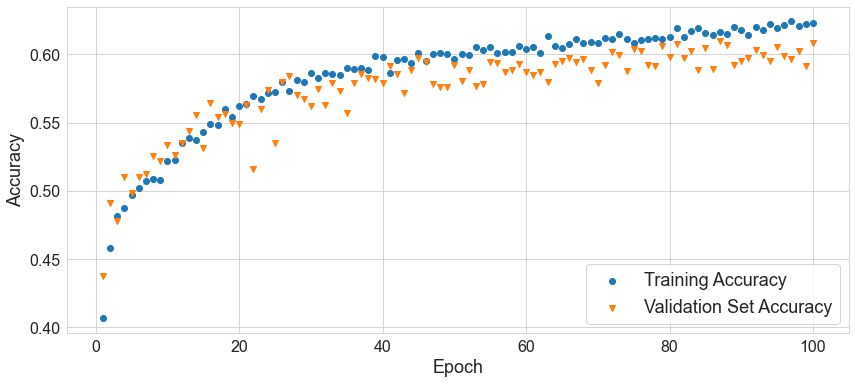

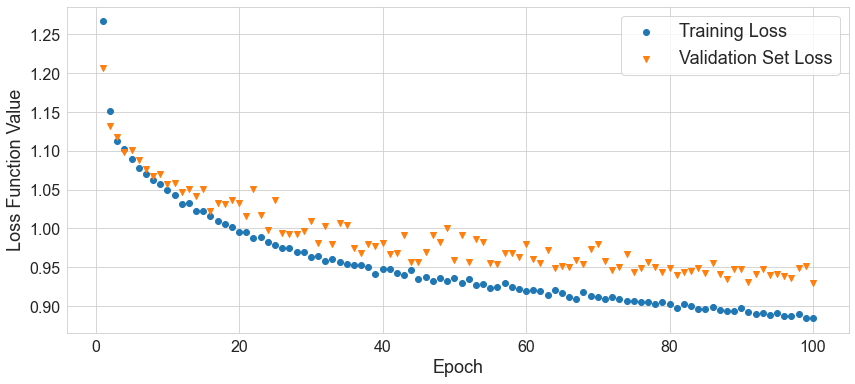

In [57]:
plt.figure(figsize = (14,6))

plt.scatter(range(1,n_epochs+1), history_dict['accuracy'], label = "Training Accuracy")
plt.scatter(range(1,n_epochs+1), history_dict['val_accuracy'], marker='v', label = "Validation Set Accuracy")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()


plt.figure(figsize = (14,6))

plt.scatter(range(1,n_epochs+1), history_dict['loss'], label = "Training Loss")
plt.scatter(range(1,n_epochs+1), history_dict['val_loss'], marker='v', label = "Validation Set Loss")

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss Function Value", fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=18)

plt.show()

In [58]:
pred=np.argmax(md.predict(X_train), axis=1)
pred

373/373 [==============================] - 0s 980us/step


array([3, 2, 3, ..., 2, 2, 3], dtype=int64)

In [59]:
def accuracy(true, predicted):
    return np.sum(true==predicted)/len(predicted)
print("Training Accuracy:", accuracy(y_train, pred))

Training Accuracy: 0.6234278047962435


In [61]:
from sklearn.metrics import accuracy_score
np.round(100*accuracy_score(y_test, np.argmax(md.predict(X_test), axis=1)),2)

94/94 [==============================] - 0s 1ms/step


60.13

In [63]:
from sklearn.metrics import accuracy_score
np.round(100*accuracy_score(y_train, np.argmax(md.predict(X_train), axis=1)),2)

373/373 [==============================] - 0s 1ms/step


62.34

In [65]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_train,np.argmax(md.predict(X_train), axis=1))
pd.DataFrame(conf_mat,
                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2','Predicted 3'],
                 index = ['Actual 0', 'Actual 1', 'Actual 2','Actual 3'])

373/373 [==============================] - 0s 974us/step


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,1595,202,337,523
Actual 1,348,1506,655,470
Actual 2,414,466,2501,371
Actual 3,286,183,236,1833


In [67]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test,np.argmax(md.predict(X_test), axis=1))
pd.DataFrame(conf_mat,
                 columns = ['Predicted 0', 'Predicted 1', 'Predicted 2','Predicted 3'],
                 index = ['Actual 0', 'Actual 1', 'Actual 2','Actual 3'])

94/94 [==============================] - 0s 1ms/step


,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,382,53,104,125
Actual 1,93,361,158,133
Actual 2,108,133,600,97
Actual 3,61,52,72,450
